<a href="https://colab.research.google.com/github/lanyu0322/pedestrian_firstdraft_figures/blob/master/figure6_plotting_top5%26least5_4_pop_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.ndimage.filters import uniform_filter as uf


# -- install geopandas
try:
  import geopandas as gp
except:
  !pip install geopandas

     |████████████████████████████████| 931kB 1.6MB/s 
     |████████████████████████████████| 14.7MB 290kB/s 
     |████████████████████████████████| 10.9MB 32.3MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# -- read in the top five and the least five parkareas
npname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "avg_nopark.csv")

pname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "avg_park.csv")
avg_nopark = pd.read_csv(npname).T
avg_park = pd.read_csv(pname).T

# -- read in the average weekend counts
fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                     "avg_weekend_ts.feather")
weekend = uf(pd.read_feather(fname)["avg_counts"].values, 8)


In [ ]:
# -- define gaussian
def gauss(xarr, x0, sig, scl):
  """ Create a 1D Gaussian """
  
  amp = scl / (sig * np.sqrt(2.0 * np.pi))
  val = -0.5 * ((xarr - x0) / sig)**2
  
  return amp * np.exp(val)


# -- define model error
def res(param, xval, yval):
  m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = param
  model = gauss(xval, m1, sd1, scl1) + gauss(xval, m2, sd2, scl2) + \
            gauss(xval, m3, sd3, scl3) + wamp * wendvals + off
  return yval - model

In [ ]:
#4-population fit for average weekday counts for all cameras

# -- set inital guess
avgs  = [35, 47, 70] 
sigs  = [3, 3, 3]
scls  = [5, 5, 5]
off   = [0.5]
wamp = [6]
param = avgs + sigs + scls + wamp + off

# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
para_nopark = []  
para_park = [] 
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]

para_nopark = [least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
          args=(xval_final, avg_nopark.iloc[0])) for i in range(len(avg_nopark))]

para_park = [least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
            args=(xval_final, avg_park.iloc[0])) for i in range(len(avg_park))]

In [ ]:
parr_park = para_park[0]["x"]
sratio_park = parr_park[6]/(0.5*(parr_park[7]+parr_park[8]))
sratio_park

0.8337621426058125

In [ ]:
parr_nopark = para_nopark[0]["x"]
sratio_nopark = parr_nopark[6]/(0.5*(parr_nopark[7]+parr_nopark[8]))
sratio_nopark

0.7686201580817797

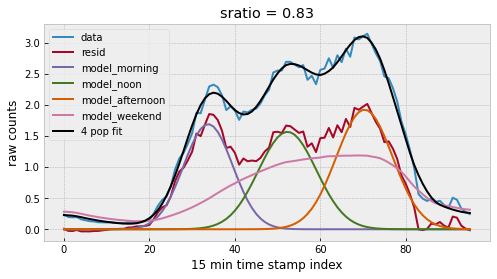

In [ ]:
#plot model 
m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = para_park[0]["x"]

model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = avg_park.iloc[0].values
resid = pdat - wamp * wendvals - off

off = off
plt.style.use("bmh")
fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(xval_final, avg_park.iloc[0], label="data")

ax.plot(resid, label="resid")
ax.plot(model1, label="model_morning")
ax.plot(model2, label="model_noon")
ax.plot(model3, label="model_afternoon")
ax.plot(wamp * wendvals, label="model_weekend")
ax.plot(model1 + model2 + model3 + wamp * wendvals + off, "k", 
        label="4 pop fit")

plt.xlabel("15 min time stamp index")
plt.ylabel("raw counts")
plt.title("sratio = 0.83")
plt.legend(loc='upper left')
plt.show()
#fig.text(0.9, 0.5, "sratio = 1.0", ha="center", va="center", rotation=-90, fontsize=14)

outfile = os.path.join("drive", "My Drive", "lwir", "output", "figure6", "park_4_pop_fit.png")
fig.savefig(outfile)

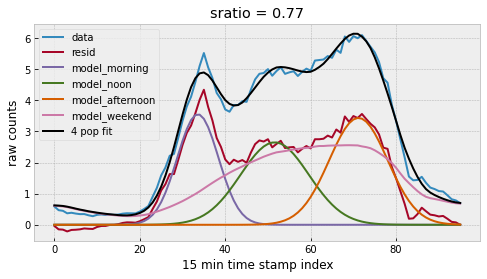

In [ ]:
#plot model 
m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = para_nopark[0]["x"]

model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = avg_nopark.iloc[0].values
resid = pdat - wamp * wendvals - off

off = off
plt.style.use("bmh")
fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(xval_final, avg_nopark.iloc[0], label="data")

ax.plot(resid, label="resid")
ax.plot(model1, label="model_morning")
ax.plot(model2, label="model_noon")
ax.plot(model3, label="model_afternoon")
ax.plot(wamp * wendvals, label="model_weekend")
ax.plot(model1 + model2 + model3 + wamp * wendvals + off, "k", 
        label="4 pop fit")

plt.xlabel("15 min time stamp index")
plt.ylabel("raw counts")
#ax.set_title("para_nopark")
plt.title("sratio = 0.77")
plt.legend()
plt.show()


outfile = os.path.join("drive", "My Drive", "lwir", "output", "figure6", "nopark_4_pop_fit.png")
fig.savefig(outfile)